# Column Propagation

Analysis of data column propagation timing across the 128 columns in PeerDAS.

In [1]:
import numpy as np
import plotly.graph_objects as go

from lib import (
    get_client_optional,
    load_or_query,
    show_fig,
    DEFAULT_NETWORK,
)

# =============================================================================
# PARAMETERS
# =============================================================================
NETWORK = DEFAULT_NETWORK
NUM_COLUMNS = 128  # Number of data columns in PeerDAS
FORCE_QUERY = False  # Set to True to refresh cached data

# =============================================================================
# SETUP
# =============================================================================
client = get_client_optional()

In [2]:
# Query column propagation data
# Build the column selection for 128 columns
col_selects = ",\n    ".join(
    [f"minIf(propagation_slot_start_diff, column_index = {i}) AS c{i}" for i in range(NUM_COLUMNS)]
)

sql_col_first_seen = f"""
SELECT
    slot_start_date_time AS time,
    {col_selects}
FROM libp2p_gossipsub_data_column_sidecar
WHERE event_date_time >= now() - INTERVAL 24 HOUR
  AND meta_network_name = '{NETWORK}'
GROUP BY slot_start_date_time
ORDER BY time
"""

df_col_first_seen = load_or_query(client, sql_col_first_seen, "col_first_seen", FORCE_QUERY)

print(f"Slots with column data: {len(df_col_first_seen)}")

Loading from cache: col_first_seen.parquet
Slots with column data: 6358


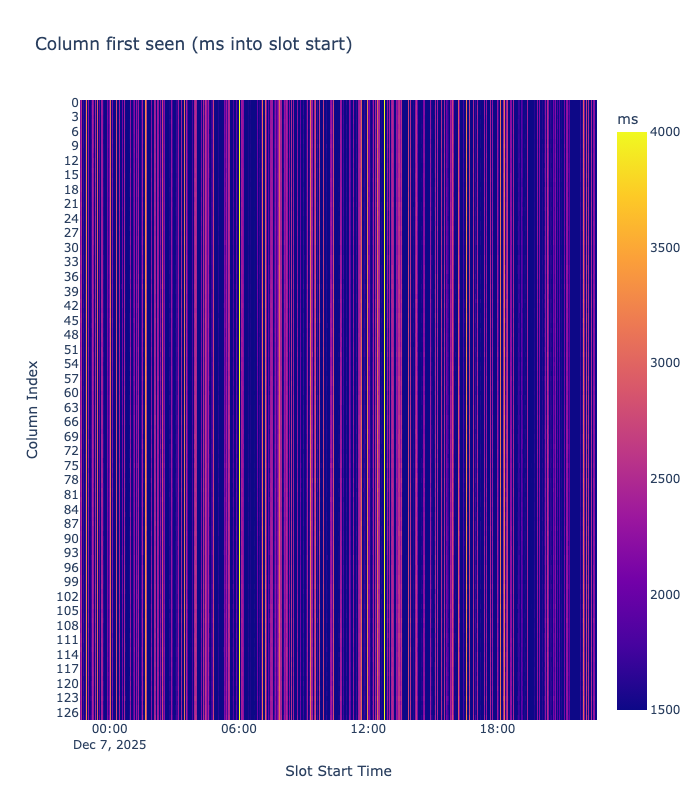

In [3]:
# Panel 1: Column first seen (ms into slot start) - 128 columns heatmap

# Reshape for heatmap: rows = columns (c0-c127), columns = time
col_names = [f"c{i}" for i in range(NUM_COLUMNS)]
df_cols = df_col_first_seen[col_names].T
df_cols.columns = df_col_first_seen["time"]

fig = go.Figure(
    data=go.Heatmap(
        z=df_cols.values,
        x=df_cols.columns,
        y=[str(i) for i in range(NUM_COLUMNS)],
        zmin=1500,
        zmax=4000,
        colorbar=dict(title="ms"),
    )
)
fig.update_layout(
    title="Column first seen (ms into slot start)",
    xaxis_title="Slot Start Time",
    yaxis_title="Column Index",
    yaxis=dict(autorange="reversed"),
    height=800,
)
show_fig(fig)

## Delta from fastest column (intraslot, ms)

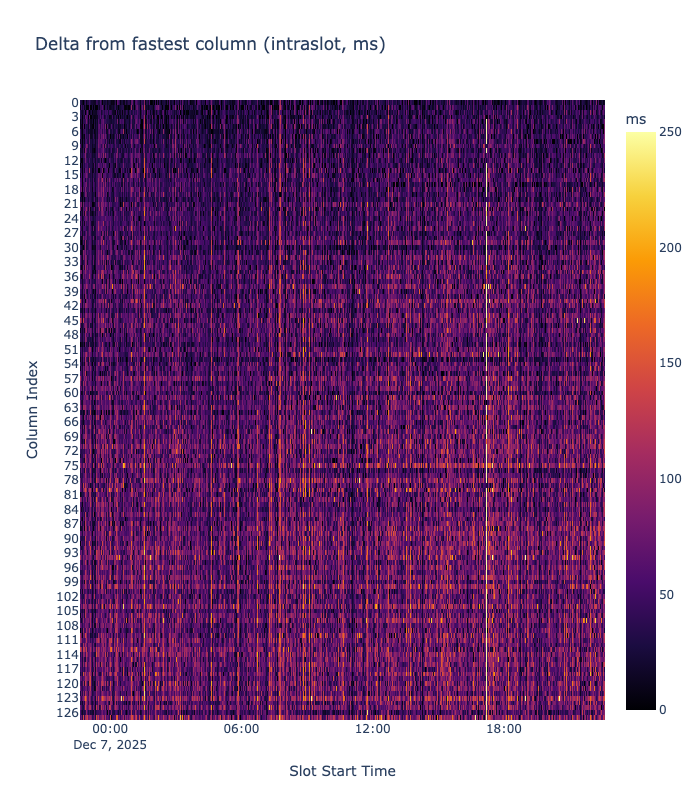

In [4]:
# Compute delta from min value per slot for each column
col_names = [f"c{i}" for i in range(NUM_COLUMNS)]
df_delta = df_col_first_seen.copy()

# Calculate row-wise minimum and subtract from each column
row_mins = df_delta[col_names].min(axis=1)
for col in col_names:
    df_delta[col] = df_delta[col] - row_mins

# Reshape for heatmap
df_delta_cols = df_delta[col_names].T
df_delta_cols.columns = df_delta["time"]

fig = go.Figure(
    data=go.Heatmap(
        z=df_delta_cols.values,
        x=df_delta_cols.columns,
        y=[str(i) for i in range(NUM_COLUMNS)],
        colorscale="Inferno",
        reversescale=False,
        zmin=0,
        zmax=250,
        colorbar=dict(title="ms"),
    )
)
fig.update_layout(
    title="Delta from fastest column (intraslot, ms)",
    xaxis_title="Slot Start Time",
    yaxis_title="Column Index",
    yaxis=dict(autorange="reversed"),
    height=800,
)
show_fig(fig)

## Delta normalized (0-1)

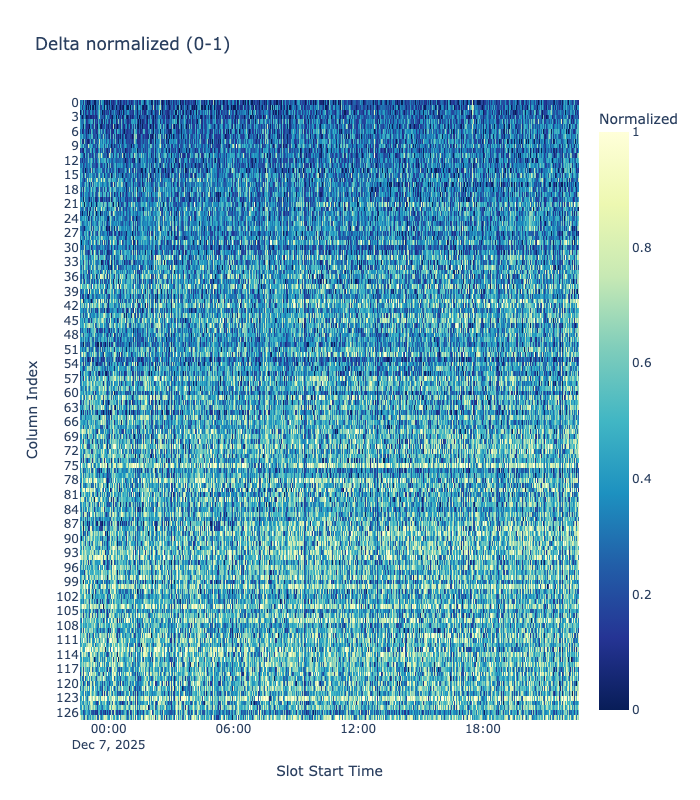

In [5]:
# Normalize delta values to 0-1 range per slot
col_names = [f"c{i}" for i in range(NUM_COLUMNS)]
df_normalized = df_col_first_seen.copy()

# Calculate row-wise min and max, then normalize
row_mins = df_normalized[col_names].min(axis=1)
row_maxs = df_normalized[col_names].max(axis=1)
row_ranges = row_maxs - row_mins

for col in col_names:
    df_normalized[col] = (df_normalized[col] - row_mins) / row_ranges.replace(0, np.nan)

# Reshape for heatmap
df_norm_cols = df_normalized[col_names].T
df_norm_cols.columns = df_normalized["time"]

fig = go.Figure(
    data=go.Heatmap(
        z=df_norm_cols.values,
        x=df_norm_cols.columns,
        y=[str(i) for i in range(NUM_COLUMNS)],
        colorscale="YlGnBu",
        reversescale=True,
        zmin=0,
        zmax=1,
        colorbar=dict(title="Normalized"),
    )
)
fig.update_layout(
    title="Delta normalized (0-1)",
    xaxis_title="Slot Start Time",
    yaxis_title="Column Index",
    yaxis=dict(autorange="reversed"),
    height=800,
)
show_fig(fig)